## Importing The Modules

In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from IPython.display import display, Image
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import DenseNet121

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import os

# Data Loading and Preprocessing

In [2]:
#  write the  code for mounting your Google Drive
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [3]:
#write the code for unzipping the data and storing it in Google Drive
!unzip /content/dataset.zip

Archive:  /content/dataset.zip
  inflating: Moon_jellyfish/01.jpg   
  inflating: Moon_jellyfish/02.jpg   
  inflating: Moon_jellyfish/03.jpg   
  inflating: Moon_jellyfish/04.jpg   
  inflating: Moon_jellyfish/05.jpg   
  inflating: Moon_jellyfish/06.jpg   
  inflating: Moon_jellyfish/08.jpg   
  inflating: Moon_jellyfish/10.jpg   
  inflating: Moon_jellyfish/12.jpg   
  inflating: Moon_jellyfish/13.jpg   
  inflating: Moon_jellyfish/14.jpg   
  inflating: Moon_jellyfish/16.jpg   
  inflating: Moon_jellyfish/17.jpg   
  inflating: Moon_jellyfish/18.jpg   
  inflating: Moon_jellyfish/21.jpg   
  inflating: Moon_jellyfish/22.jpg   
  inflating: Moon_jellyfish/24.jpg   
  inflating: Moon_jellyfish/25.jpg   
  inflating: Moon_jellyfish/26.jpg   
  inflating: Moon_jellyfish/28.jpg   
  inflating: Moon_jellyfish/29.JPG   
  inflating: Moon_jellyfish/30.jpg   
  inflating: Moon_jellyfish/31.jpg   
  inflating: Moon_jellyfish/32.jpg   
  inflating: Moon_jellyfish/34.jpg   
  inflating: Moon_j

In [4]:
moon_jellyfish_folder = "/content/Moon_jellyfish"
barrel_jellyfish_folder = "/content/barrel_jellyfish"
blue_jellyfish_folder = "/content/blue_jellyfish"
compass_jellyfish_folder = "/content/compass_jellyfish"
lions_mane_jellyfish_folder = "/content/lions_mane_jellyfish"
mauve_stinger_jellyfish_folder = "/content/mauve_stinger_jellyfish"


##functions_for_loading_images
def load_images_from_folder(folder):
  images = []
  for filename in os.listdir(folder):
    img = cv2.imread(os.path.join(folder,filename))
    if img is not  None:
      img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
      img = cv2.resize(img,(224,224))
      images.append(img)

  return images

# Load images and labels for each emotion
moon_jellyfish = load_images_from_folder(moon_jellyfish_folder)
barrel_jellyfish = load_images_from_folder(barrel_jellyfish_folder)
blue_jellyfish = load_images_from_folder(blue_jellyfish_folder)
compass_jellyfish = load_images_from_folder(compass_jellyfish_folder)
lions_jellyfish = load_images_from_folder(lions_mane_jellyfish_folder)
mauve_stinger_jellyfish = load_images_from_folder(mauve_stinger_jellyfish_folder)

In [5]:
# Create labels
Moon_labels = [0] * len(moon_jellyfish)
barrel_labels = [1] * len(barrel_jellyfish)
blue_labels = [2] * len(blue_jellyfish)
compass_labels = [3] * len(compass_jellyfish)
lions_mane_labels = [4] * len(lions_jellyfish)
mauve_stinger_labels = [5] * len(mauve_stinger_jellyfish)

all_labels = Moon_labels+barrel_labels+blue_labels+compass_labels+lions_mane_labels+mauve_stinger_labels


In [6]:
print('Moon_jellyfish_images: ',len(moon_jellyfish))
print('barrel_jellyfish_images: ',len(barrel_jellyfish))
print('blue_jellyfish_images: ',len(blue_jellyfish))
print('compass_jellyfish_images: ',len(compass_jellyfish))
print('lions_mane_jellyfish_images: ',len(lions_jellyfish))
print('mauve_stinger_jellyfish_images: ',len(mauve_stinger_jellyfish))

Moon_jellyfish_images:  150
barrel_jellyfish_images:  150
blue_jellyfish_images:  150
compass_jellyfish_images:  150
lions_mane_jellyfish_images:  150
mauve_stinger_jellyfish_images:  150


In [7]:
from keras.utils import to_categorical
# Concatenate images and labels
x = np.array(moon_jellyfish + barrel_jellyfish + blue_jellyfish + compass_jellyfish + lions_jellyfish + mauve_stinger_jellyfish)

y = np.array(Moon_labels+barrel_labels+blue_labels+compass_labels+lions_mane_labels+mauve_stinger_labels
)

x = x.astype('float32')/255

# One-hot encode the labels
y = to_categorical(y, 6)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [8]:
##resizing the image
input_shape_densenet = (224,224,3)

def resize_images(input_shape,images):
  resized_images = []
  for img in images:
    img_resized = cv2.resize(img,(input_shape[0],input_shape[1]))
    img_resized = np.expand_dims(img_resized,axis=-1)
    img_resized = np.repeat(img_resized,3,axis=-1)
    resized_images.append(img_resized)
  return np.array(resized_images)


In [9]:
x_train_densenet = resize_images(images=X_train,input_shape=input_shape_densenet)
x_test_densenet = resize_images(images=X_test,input_shape=input_shape_densenet)

## Training and Evaluation

In [10]:
## using densenet premodel using imagenet weights and keeping starting layers as constant
densenet_base_model = DenseNet121(weights='imagenet',include_top=False,input_shape=input_shape_densenet)
densenet_base_model.trainable = False

densenet_avgpool = GlobalAveragePooling2D()(densenet_base_model.output)
densenet_activation = Dense(6,activation='softmax')(densenet_avgpool)
densenet_model = Model(inputs=densenet_base_model.input,outputs=densenet_activation)

densenet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

29084464/29084464 [==============================] - 1s 0us/step


In [11]:
densenet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']      

In [12]:
history = densenet_model.fit(x_train_densenet, y_train, batch_size=32, epochs=20,validation_data=(x_test_densenet,y_test))

Epoch 1/20
23/23 [==============================] - 181s 7s/step - loss: 1.8653 - accuracy: 0.2319 - val_loss: 1.4167 - val_accuracy: 0.4278
Epoch 2/20
23/23 [==============================] - 179s 8s/step - loss: 1.1812 - accuracy: 0.5639 - val_loss: 1.0266 - val_accuracy: 0.6556
Epoch 3/20
23/23 [==============================] - 178s 8s/step - loss: 0.8647 - accuracy: 0.7347 - val_loss: 0.8558 - val_accuracy: 0.7111
Epoch 4/20
23/23 [==============================] - 180s 8s/step - loss: 0.6935 - accuracy: 0.7986 - val_loss: 0.7577 - val_accuracy: 0.7444
Epoch 5/20
23/23 [==============================] - 177s 8s/step - loss: 0.5903 - accuracy: 0.8389 - val_loss: 0.6860 - val_accuracy: 0.7889
Epoch 6/20
23/23 [==============================] - 174s 8s/step - loss: 0.5152 - accuracy: 0.8597 - val_loss: 0.6453 - val_accuracy: 0.7944
Epoch 7/20
23/23 [==============================] - 173s 8s/step - loss: 0.4601 - accuracy: 0.8833 - val_loss: 0.6045 - val_accuracy: 0.7889
Epoch 8/20
23

In [13]:
densenet_accuracy = densenet_model.evaluate(x_test_densenet,y_test)
print("The Densenet loss :",densenet_accuracy[0])
print("The Densenet Accuracy :",densenet_accuracy[1])

6/6 [==============================] - 36s 6s/step - loss: 0.3517 - accuracy: 0.8611
The Densenet loss : 0.3516521751880646
The Densenet Accuracy : 0.8611111044883728


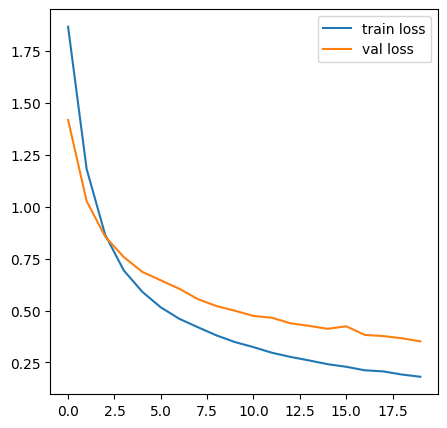

<Figure size 640x480 with 0 Axes>

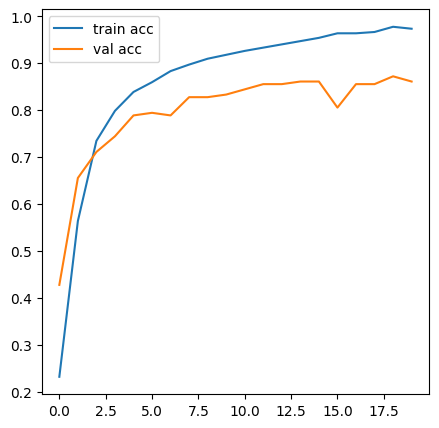

<Figure size 640x480 with 0 Axes>

In [19]:
import matplotlib.pyplot as plt

# plot the loss
plt.figure(figsize=(5,5))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

print('\n')

# plot the accuracy
plt.figure(figsize=(5,5))
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')
